<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goal" data-toc-modified-id="Goal-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goal</a></span></li><li><span><a href="#Var" data-toc-modified-id="Var-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Var</a></span></li><li><span><a href="#Init" data-toc-modified-id="Init-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Init</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load</a></span><ul class="toc-item"><li><span><a href="#Metadata" data-toc-modified-id="Metadata-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Metadata</a></span></li><li><span><a href="#beta-diversity" data-toc-modified-id="beta-diversity-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>beta-diversity</a></span></li></ul></li><li><span><a href="#aPCoA" data-toc-modified-id="aPCoA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>aPCoA</a></span></li><li><span><a href="#sessionInfo" data-toc-modified-id="sessionInfo-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>sessionInfo</a></span></li></ul></div>

# Goal

* Run [adjusted PCoA](https://arxiv.org/pdf/2003.09544.pdf) on beta diversity measures
* Adjust for dataset batch effects

# Var

In [16]:
# working dir
work_dir = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/'

# metadata
## filtered
metadata_filt_file = file.path(work_dir, 'CurMetDat_metadata_filt-n1846.tsv')
## all 
base_in_dir = '/ebio/abt3_projects/small_projects/nyoungblut/public_data_retireval/'
metadata_file = file.path(base_in_dir, 'CurMetDat-metagenomes', 'files', 'metadata', 'Filtered_CurMetDat_f.tsv')

# ref genome metadata (GTDBr89 metadata)
genome_meta_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/metadata_1per-GTDB-Spec_gte50comp-lt5cont_wtaxID_wPath.tsv'

# trees
## GTDB phylogeny
phy_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/phylogeny/ar122-bac120_r89_1per-GTDB-Spec_gte50comp-lt5cont_rn.nwk'
## trait phylogeny
phy_trt_file = '/ebio/abt3_projects/databases_no-backup/GTDB/release89/LLMGP-DB/genomes/LLG//phenotype/predictions_flat_majority-votes_combined_jaccard_rn.nwk'


# beta-diversity
dist_names1 = list('bray'='bray', 'jaccard'='jaccard', 
                  'wunifrac'='wunifrac', 'unifrac'='unifrac')
dist_names2 = list('wunifrac'='wunifrac', 'unifrac'='unifrac')
dist_F1 = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/beta-div.qs'
dist_F2 = '/ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/beta-div_trt-maj.qs'

# params
threads = 16

# Init

In [19]:
library(dplyr)
library(tidyr)
library(ggplot2)
library(data.table)
library(dtplyr)
library(tidytable)
library(ape)
library(phyloseq)
library(vegan)
library(aPCoA)
library(LeyLabRMisc)

In [56]:
df.dims()
setDTthreads(threads)
RhpcBLASctl::blas_set_num_threads(1)
make_dir(work_dir)

Directory already exists: /ebio/abt3_projects/databases_no-backup/curatedMetagenomicData/global_metagenomes/diversity/ 


# Load

## Metadata

In [35]:
# all 
meta = Fread(metadata_file) %>%
    dt_mutate(Sample = gsub('-', '.', Sample)) %>%
    dt_filter(number_reads >= 5e5) %>%
    dt_mutate(dataset_name = dataset_name %>% as.factor,
              study_condition = study_condition %>% as.factor)
meta %>% unique_n('Samples', Sample)
meta

No. of unique Samples: 3582 


dataset_name  Sample              subjectID body_site
1    AsnicarF_2017 MV_FEM1_t1Q14       MV_FEM1   stool    
2    AsnicarF_2017 MV_FEM2_t1Q14       MV_FEM2   stool    
⋮    ⋮             ⋮                   ⋮         ⋮        
3581 ZellerG_2014  CCIS82944710ST.20.0 FR-730    stool    
3582 ZellerG_2014  CCIS93040568ST.20.0 FR-682    stool    
     antibiotics_current_use study_condition disease age age_category gender ⋯
1    NA                      control         healthy NA  adult        female ⋯
2    NA                      control         healthy NA  adult        female ⋯
⋮    ⋮                       ⋮               ⋮       ⋮   ⋮            ⋮      ⋱
3581 NA                      control         healthy 38  adult        female ⋯
3582 NA                      control         healthy 65  adult        male   ⋯
     il_1 glp_1 travel_destination urea_nitrogen disease_stage
1    NA   NA    NA                 NA            NA           
2    NA   NA    NA                 NA            NA           
⋮    ⋮    ⋮     ⋮                  ⋮             ⋮            
3581 NA   NA    NA                 NA            NA           
3582 NA   NA    NA                 NA            NA           
     uncurated_metadata family_member subject_n samp_n westernized
1    NA                 NA            1         1      TRUE       
2    NA                 NA            1         1      TRUE       
⋮    ⋮                  ⋮             ⋮         ⋮      ⋮          
3581 NA                 NA            1         1      TRUE       
3582 NA                 NA            1         1      TRUE

In [36]:
# filtered
meta_f = Fread(metadata_filt_file) %>%
    dt_mutate(Sample = gsub('-', '.', Sample)) %>%
    dt_filter(number_reads >= 5e5) %>%
    dt_mutate(dataset = dataset %>% as.factor,
              study_condition = study_condition %>% as.factor)
meta_f %>% unique_n('Samples', Sample)
meta_f

No. of unique Samples: 1802 


dataset               Sample      Run Lane Remote     subjectID    
1    Bengtsson-PalmeJ_2015 TRAVELRES1  1   1    ERR636349  TRAVELRES1_2 
2    Bengtsson-PalmeJ_2015 TRAVELRES10 1   1    ERR636358  TRAVELRES9_10
⋮    ⋮                     ⋮           ⋮   ⋮    ⋮          ⋮            
4264 YeZ_2018              YEZ_N.38    1   1    SRR8675918 YEZ_N-38     
4265 YeZ_2018              YEZ_N.37    1   1    SRR8675921 YEZ_N-37     
     body_site antibiotics_current_use study_condition disease ⋯ il_1 glp_1
1    stool     no                      control         healthy ⋯ NA   NA   
2    stool     no                      control         healthy ⋯ NA   NA   
⋮    ⋮         ⋮                       ⋮               ⋮       ⋱ ⋮    ⋮    
4264 stool     no                      control         healthy ⋯ NA   NA   
4265 stool     no                      control         healthy ⋯ NA   NA   
     travel_destination urea_nitrogen disease_stage uncurated_metadata
1    NA                 NA            NA            NA                
2    LKA                NA            NA            NA                
⋮    ⋮                  ⋮             ⋮             ⋮                 
4264 NA                 NA            NA            NA                
4265 NA                 NA            NA            NA                
     family_member subject_n samp_n westernized
1    NA            1         1      TRUE       
2    NA            1         1      TRUE       
⋮    ⋮             ⋮         ⋮      ⋮          
4264 NA            1         1      TRUE       
4265 NA            1         1      TRUE

## beta-diversity

In [37]:
# loading as a list of distance matrices
D = list('bray' = qs::qread(dist_F1, nthreads=4)[['bray']],
         'jaccard' = qs::qread(dist_F1, nthreads=4)[['jaccard']],
         'unifrac_phy' = qs::qread(dist_F1, nthreads=4)[['unifrac']],
         'wunifrac_phy' = qs::qread(dist_F1, nthreads=4)[['wunifrac']],
         'unifrac_trt' = qs::qread(dist_F2, nthreads=4)[['unifrac']],
         'wunifrac_trt' = qs::qread(dist_F2, nthreads=4)[['wunifrac']])
D %>% names

[1] "bray"         "jaccard"      "unifrac_phy"  "wunifrac_phy" "unifrac_trt" 
[6] "wunifrac_trt"

In [38]:
# formatting metadata
m = meta %>%
    as.data.frame
rownames(m) = m$Sample
m

dataset_name  Sample              subjectID body_site
MV_FEM1_t1Q14       AsnicarF_2017 MV_FEM1_t1Q14       MV_FEM1   stool    
MV_FEM2_t1Q14       AsnicarF_2017 MV_FEM2_t1Q14       MV_FEM2   stool    
⋮                   ⋮             ⋮                   ⋮         ⋮        
CCIS82944710ST.20.0 ZellerG_2014  CCIS82944710ST.20.0 FR-730    stool    
CCIS93040568ST.20.0 ZellerG_2014  CCIS93040568ST.20.0 FR-682    stool    
                    antibiotics_current_use study_condition disease age
MV_FEM1_t1Q14       NA                      control         healthy NA 
MV_FEM2_t1Q14       NA                      control         healthy NA 
⋮                   ⋮                       ⋮               ⋮       ⋮  
CCIS82944710ST.20.0 NA                      control         healthy 38 
CCIS93040568ST.20.0 NA                      control         healthy 65 
                    age_category gender ⋯ il_1 glp_1 travel_destination
MV_FEM1_t1Q14       adult        female ⋯ NA   NA    NA                
MV_FEM2_t1Q14       adult        female ⋯ NA   NA    NA                
⋮                   ⋮            ⋮      ⋱ ⋮    ⋮     ⋮                 
CCIS82944710ST.20.0 adult        female ⋯ NA   NA    NA                
CCIS93040568ST.20.0 adult        male   ⋯ NA   NA    NA                
                    urea_nitrogen disease_stage uncurated_metadata
MV_FEM1_t1Q14       NA            NA            NA                
MV_FEM2_t1Q14       NA            NA            NA                
⋮                   ⋮             ⋮             ⋮                 
CCIS82944710ST.20.0 NA            NA            NA                
CCIS93040568ST.20.0 NA            NA            NA                
                    family_member subject_n samp_n westernized
MV_FEM1_t1Q14       NA            1         1      TRUE       
MV_FEM2_t1Q14       NA            1         1      TRUE       
⋮                   ⋮             ⋮         ⋮      ⋮          
CCIS82944710ST.20.0 NA            1         1      TRUE       
CCIS93040568ST.20.0 NA            1         1      TRUE

In [39]:
# filtering and ordering
m = m[labels(D[[1]]),]
m

dataset_name  Sample          subjectID       body_site
A01_02_1FE      PasolliE_2018 A01_02_1FE      A01_02_1FE      stool    
A02_01_1FE      PasolliE_2018 A02_01_1FE      A02_01_1FE      stool    
⋮               ⋮             ⋮               ⋮               ⋮        
YSZC12003_37879 XieH_2016     YSZC12003_37879 YSZC12003_37879 stool    
YSZC12003_37880 XieH_2016     YSZC12003_37880 YSZC12003_37880 stool    
                antibiotics_current_use study_condition disease age
A01_02_1FE      no                      control         healthy NA 
A02_01_1FE      no                      control         healthy NA 
⋮               ⋮                       ⋮               ⋮       ⋮  
YSZC12003_37879 NA                      control         NA      42 
YSZC12003_37880 NA                      control         NA      42 
                age_category gender ⋯ il_1 glp_1 travel_destination
A01_02_1FE      adult        NA     ⋯ NA   NA    NA                
A02_01_1FE      adult        NA     ⋯ NA   NA    NA                
⋮               ⋮            ⋮      ⋱ ⋮    ⋮     ⋮                 
YSZC12003_37879 adult        female ⋯ NA   NA    NA                
YSZC12003_37880 adult        female ⋯ NA   NA    NA                
                urea_nitrogen disease_stage uncurated_metadata family_member
A01_02_1FE      NA            NA            NA                 NA           
A02_01_1FE      NA            NA            NA                 NA           
⋮               ⋮             ⋮             ⋮                  ⋮            
YSZC12003_37879 NA            NA            NA                 NA           
YSZC12003_37880 NA            NA            NA                 NA           
                subject_n samp_n westernized
A01_02_1FE      1         1      FALSE      
A02_01_1FE      1         1      FALSE      
⋮               ⋮         ⋮      ⋮          
YSZC12003_37879 1         1      TRUE       
YSZC12003_37880 1         1      TRUE

# aPCoA

In [69]:
#' function for running aPCoA in parallel
aPCoA_per = function(i, D, m){
    d = D[[i]]
    aPCoA(d ~ dataset_name, m, study_condition, 
          drawEllipse=TRUE, drawCenter=FALSE) 
}

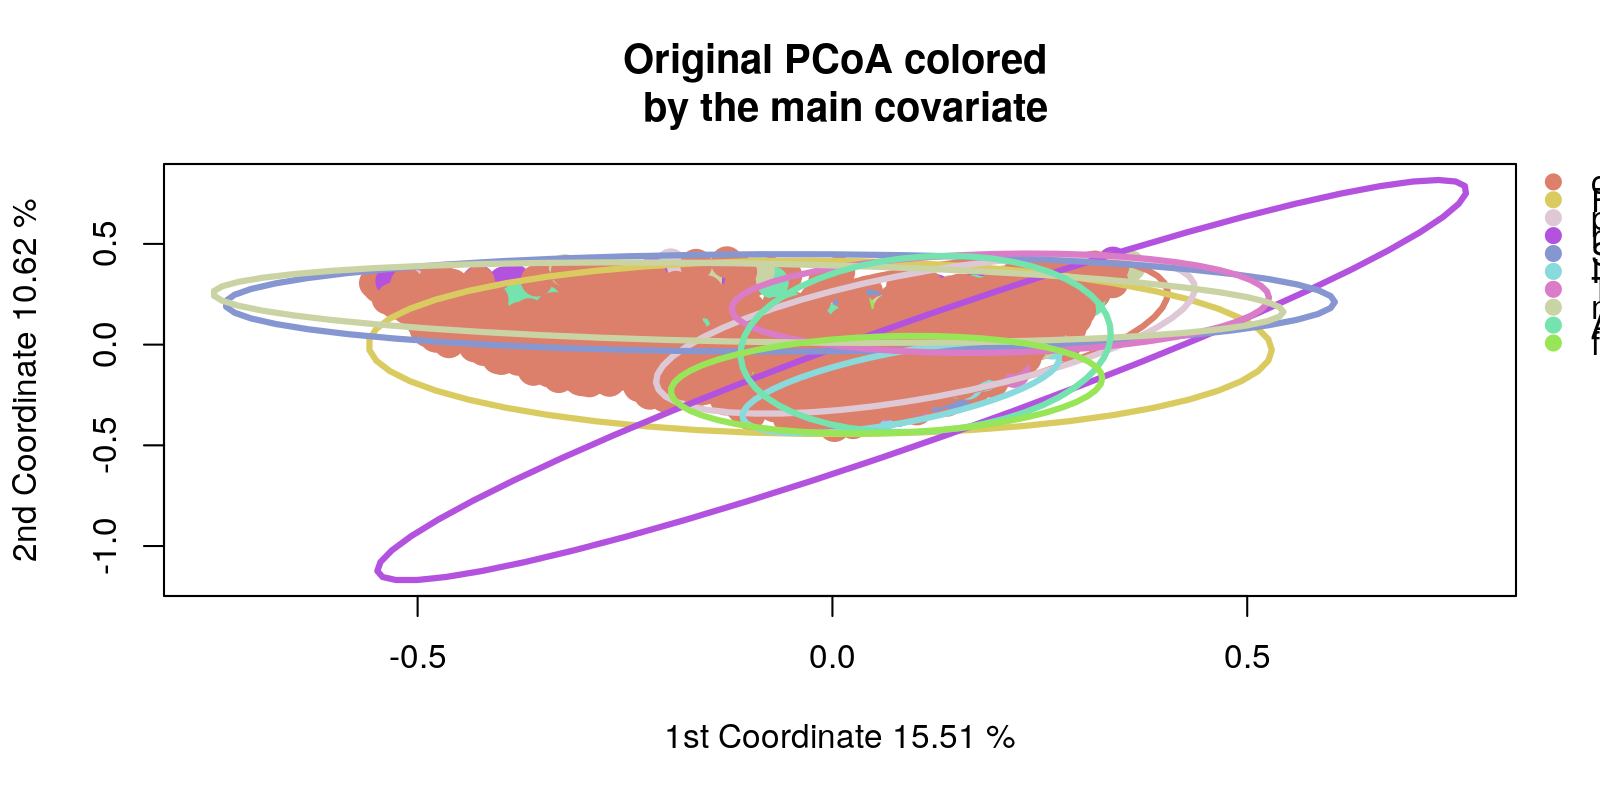

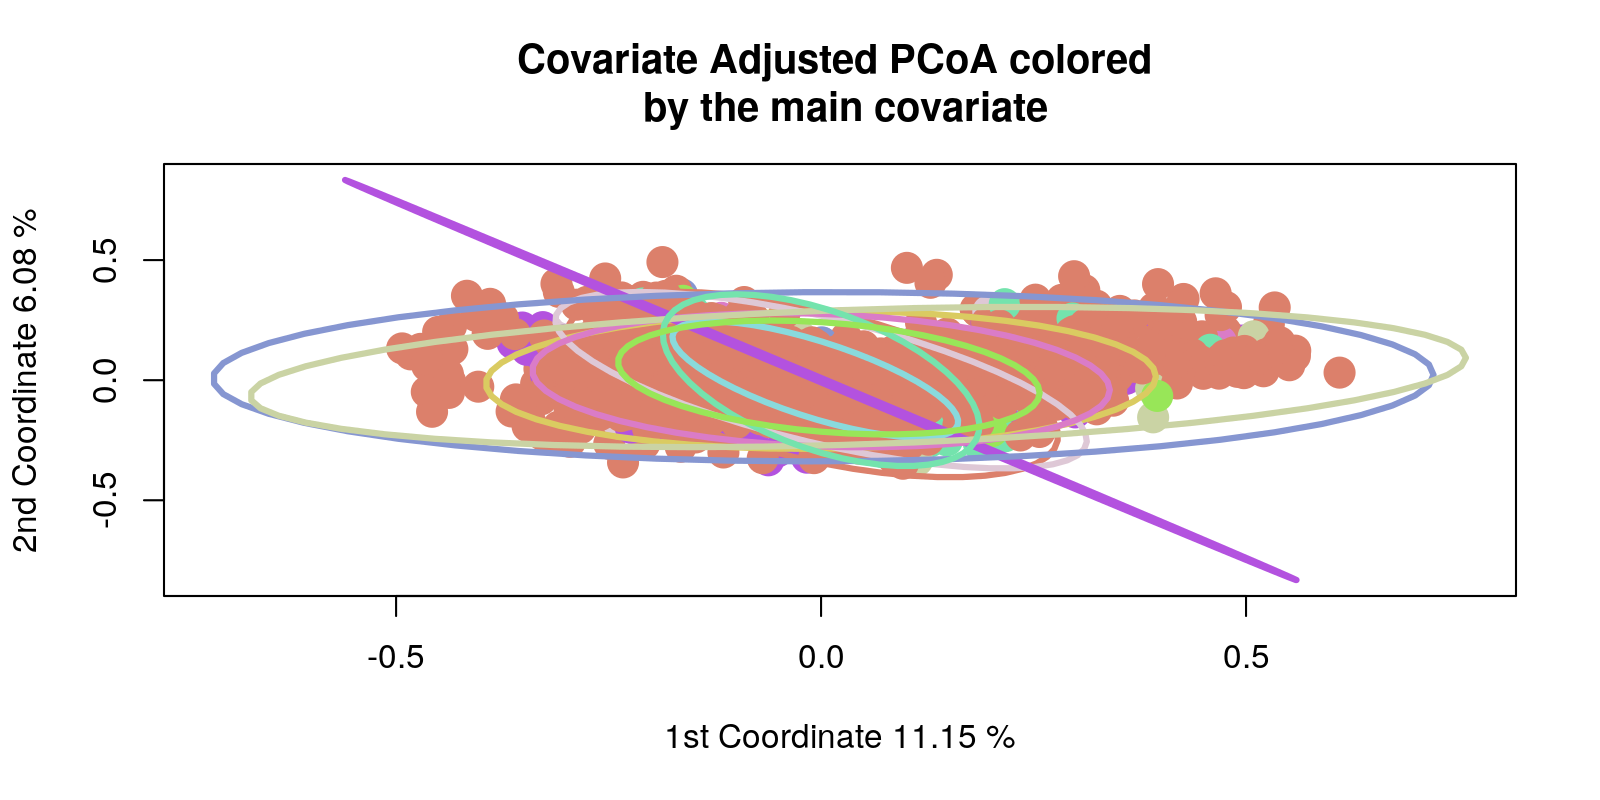

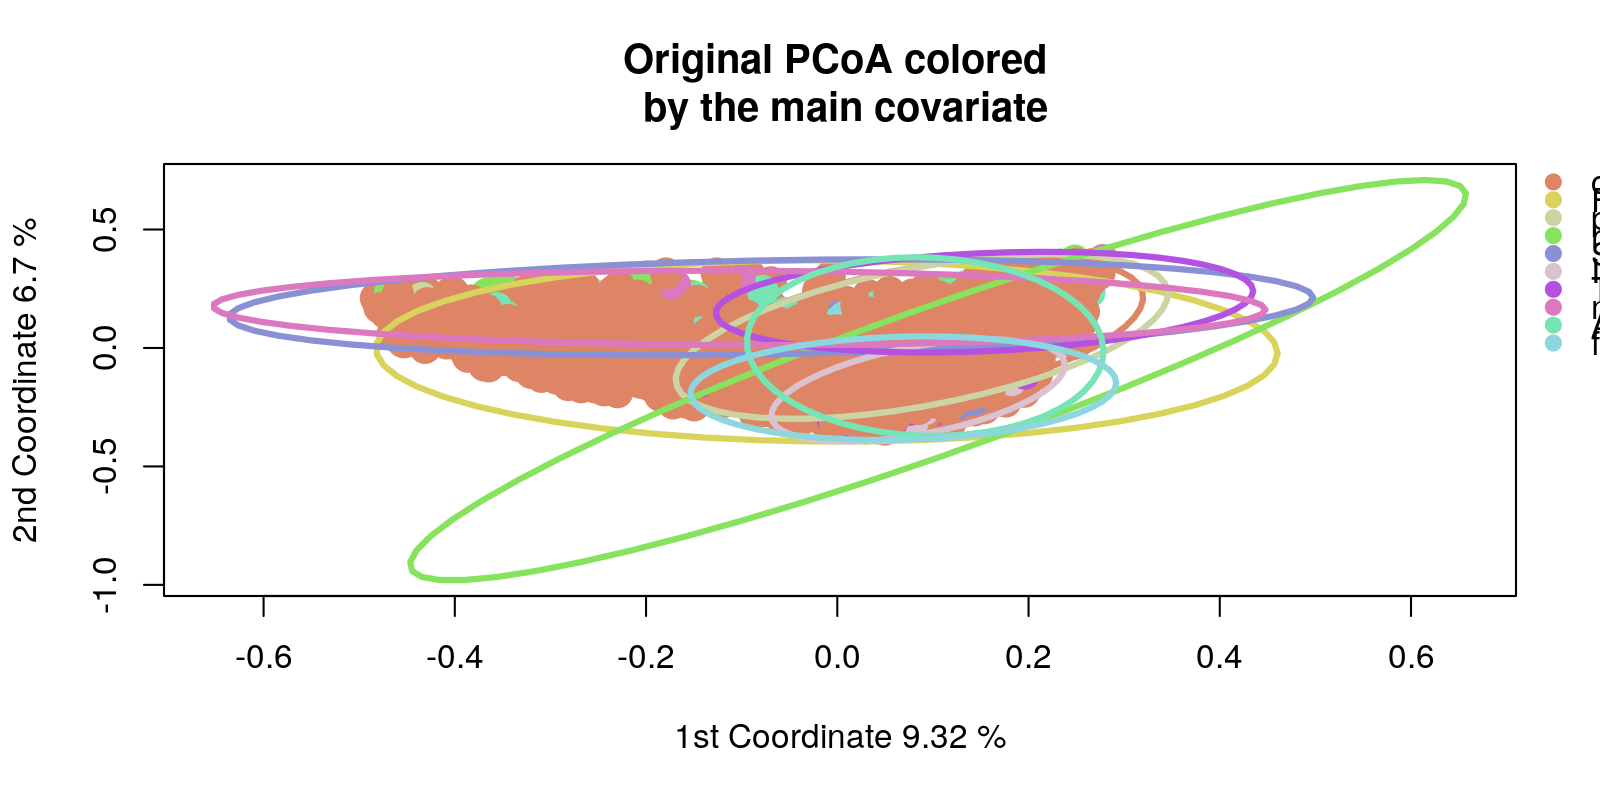

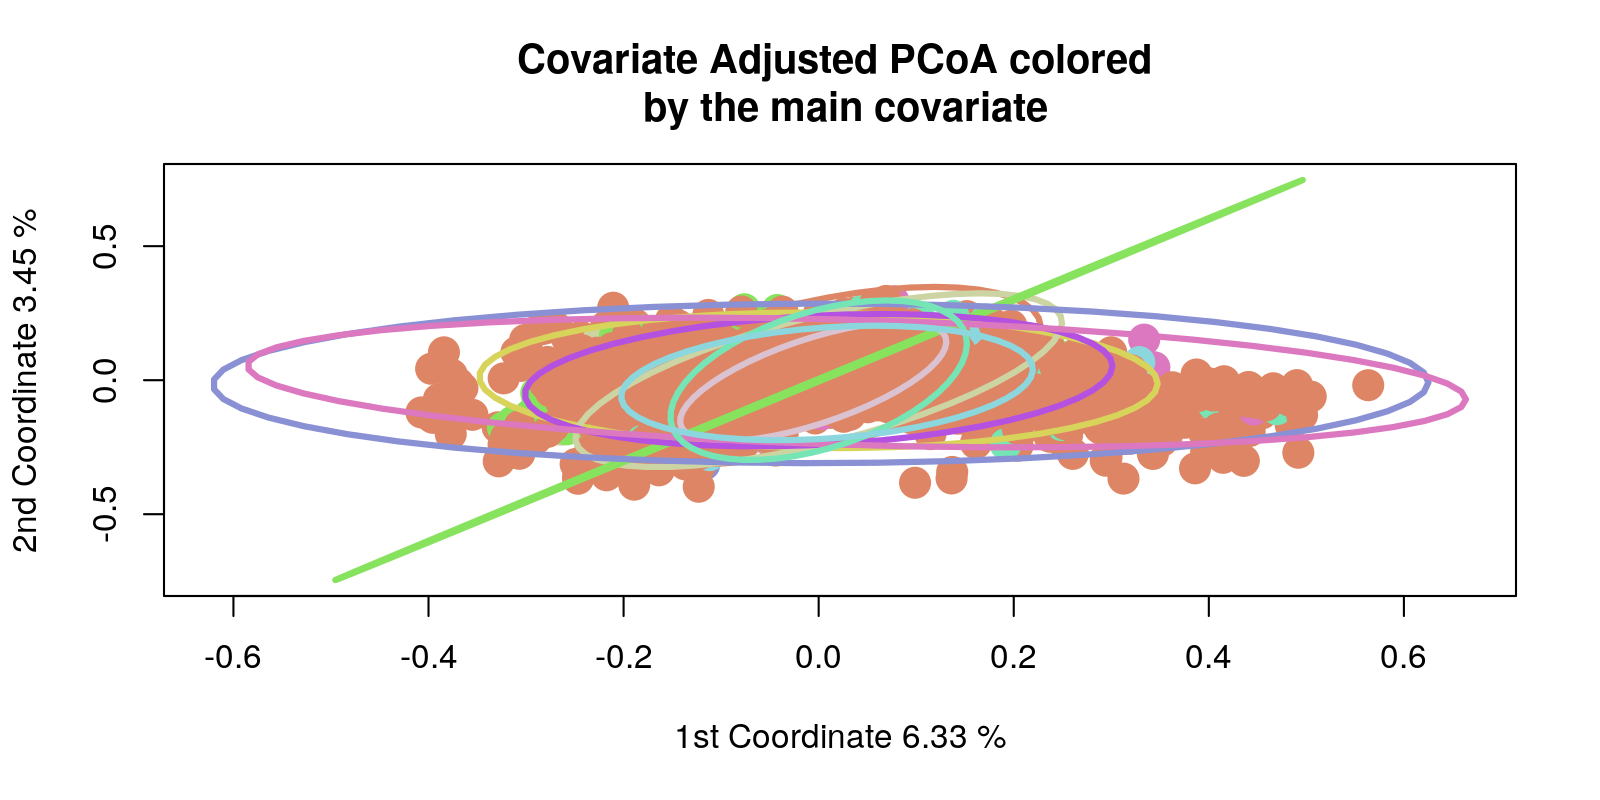

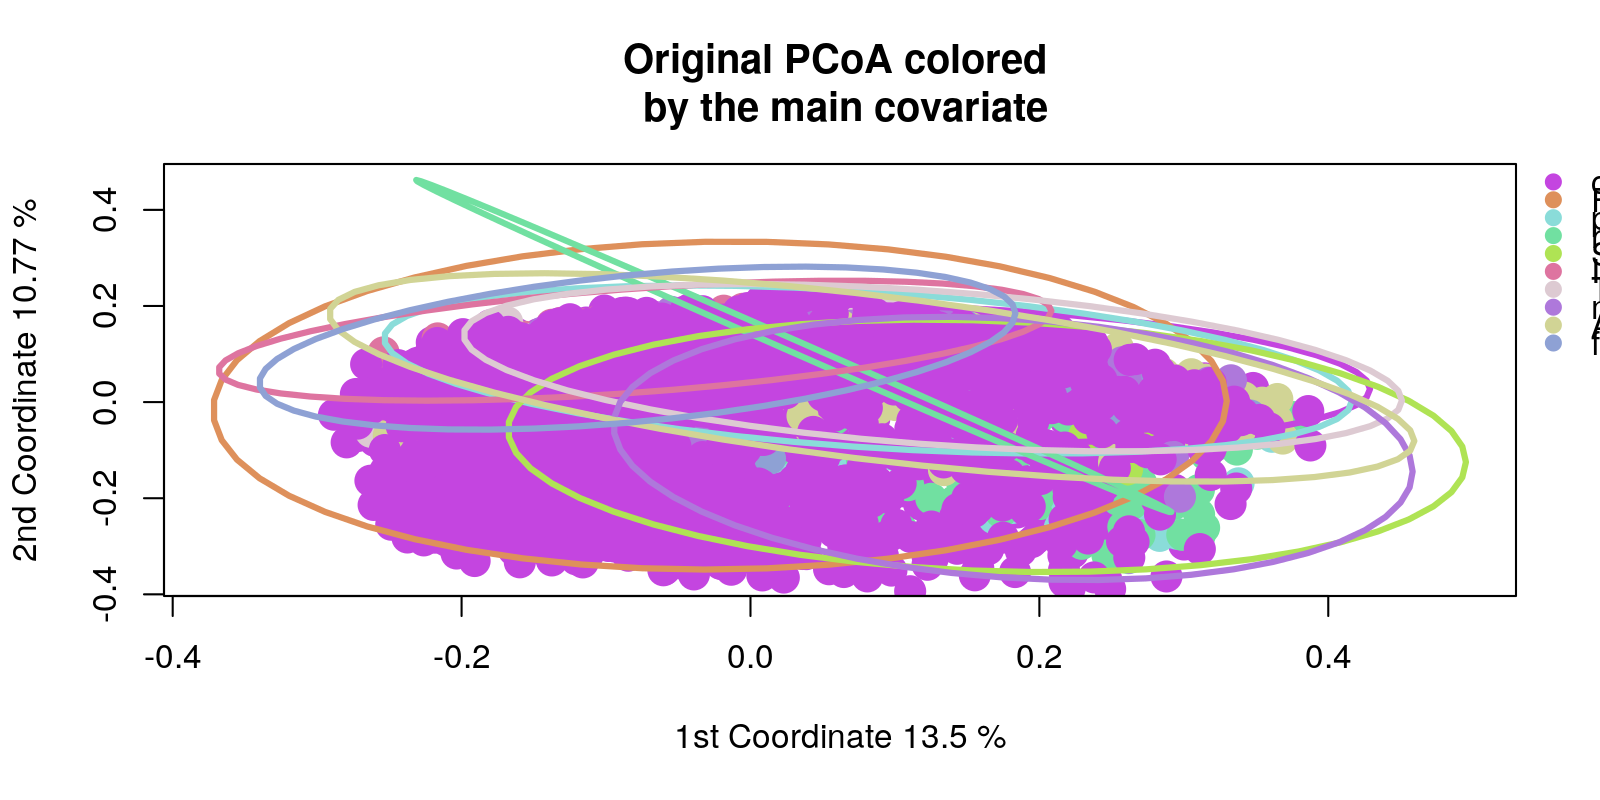

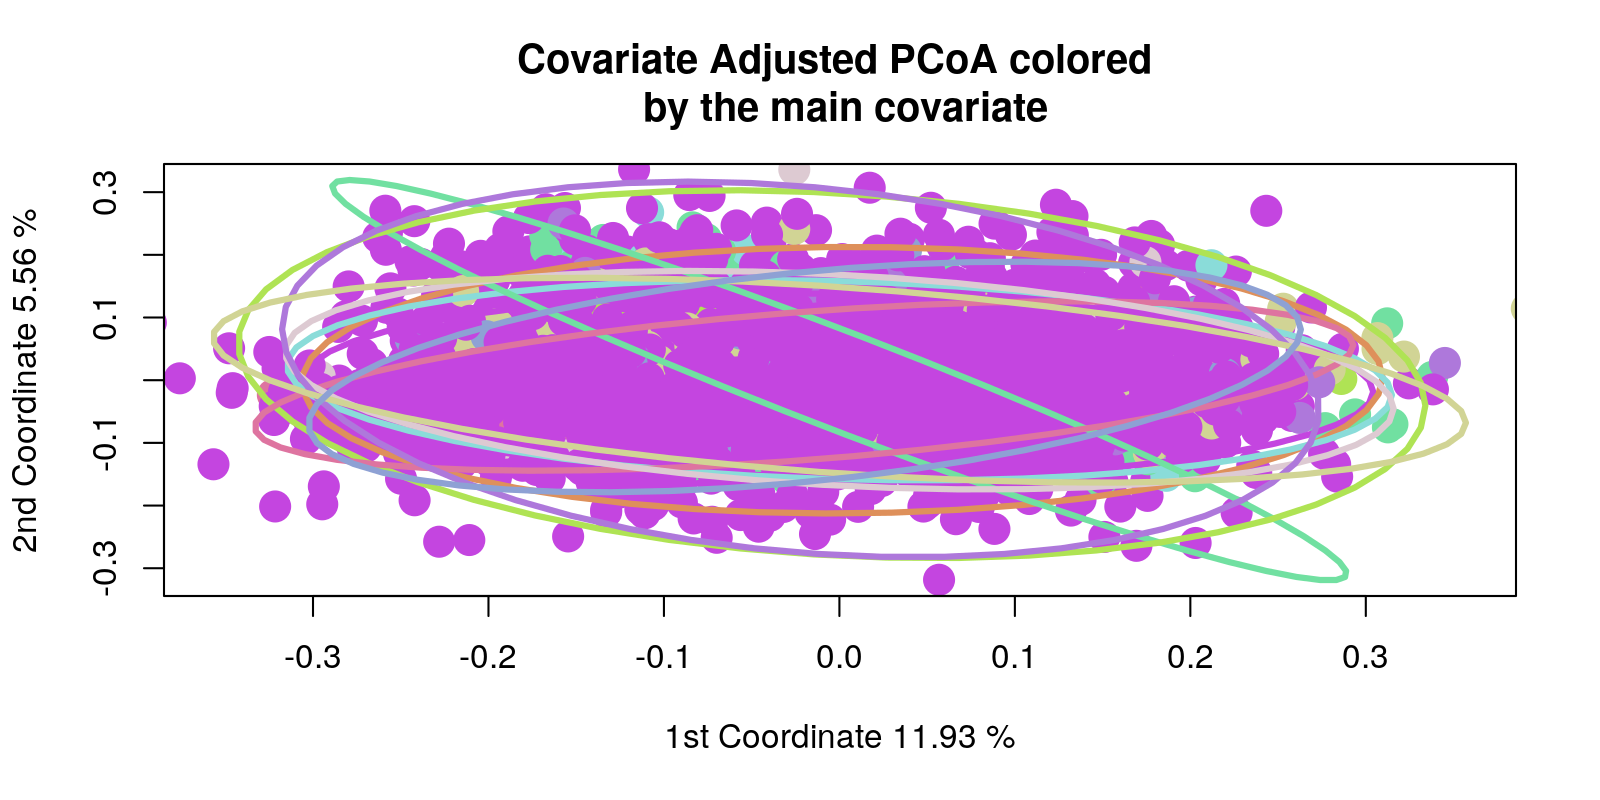

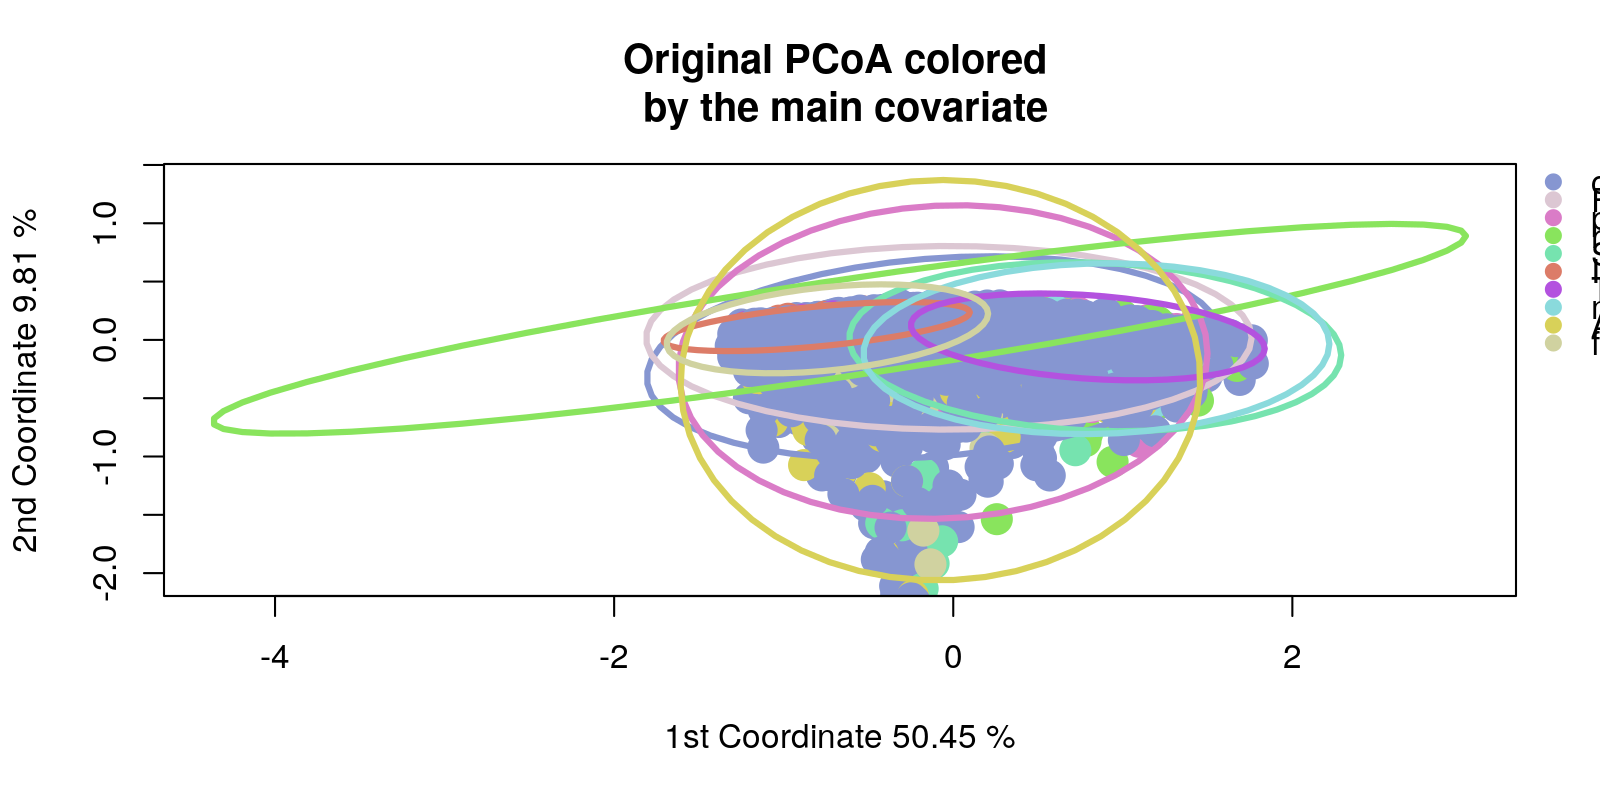

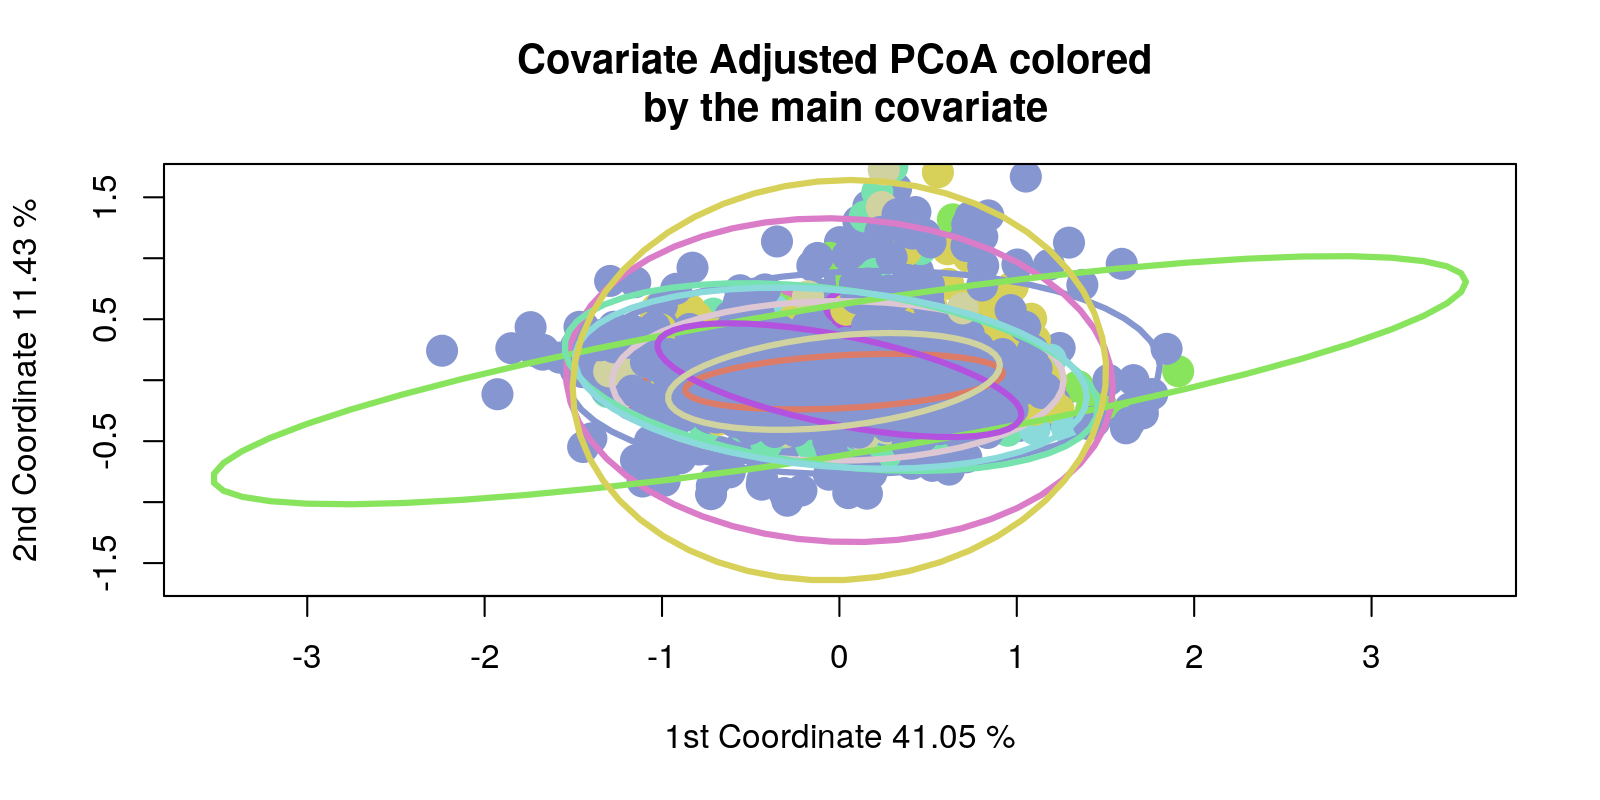

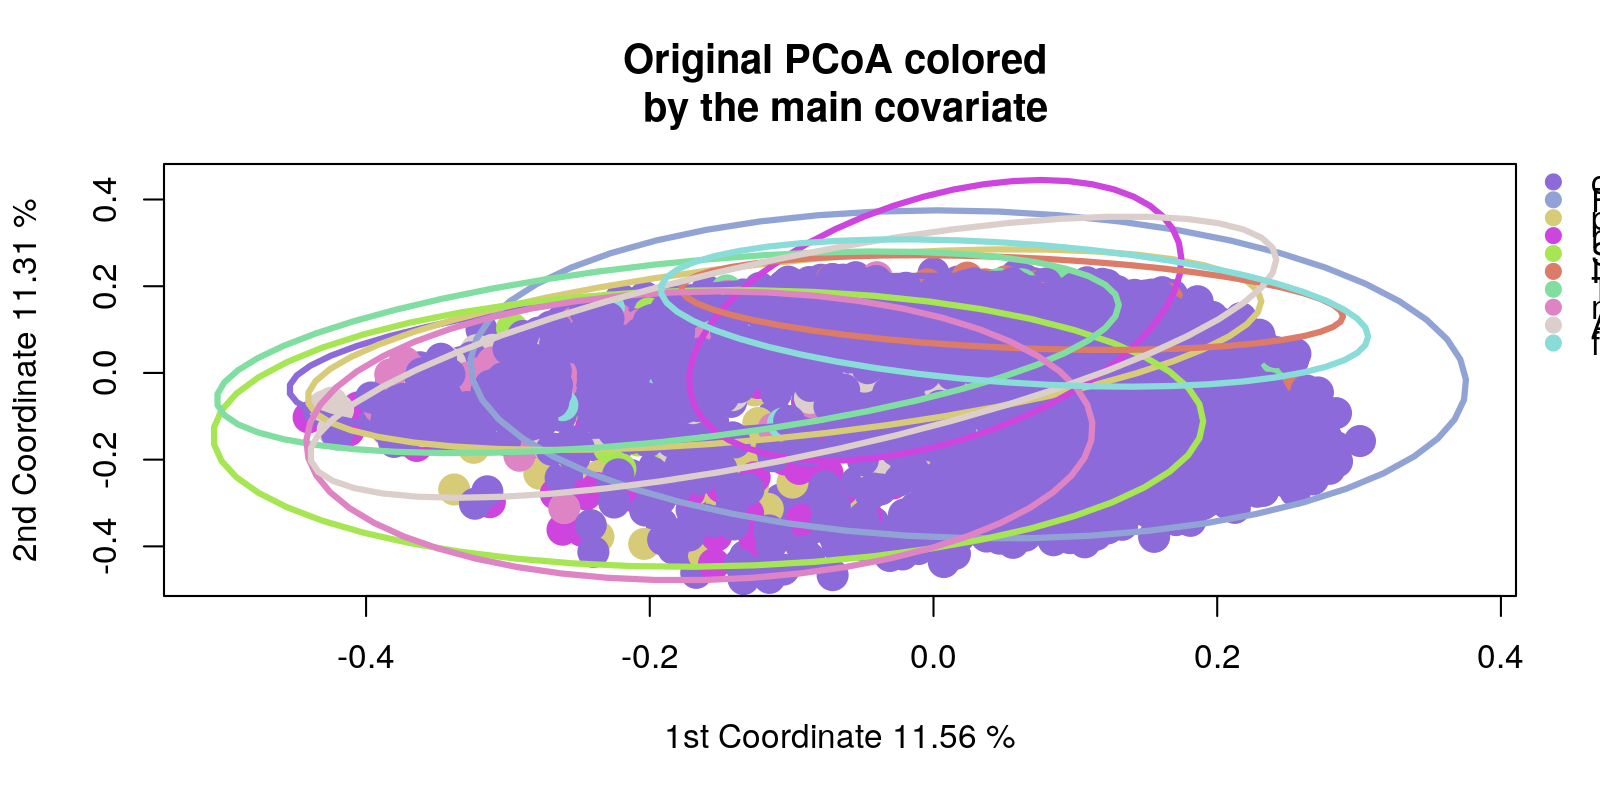

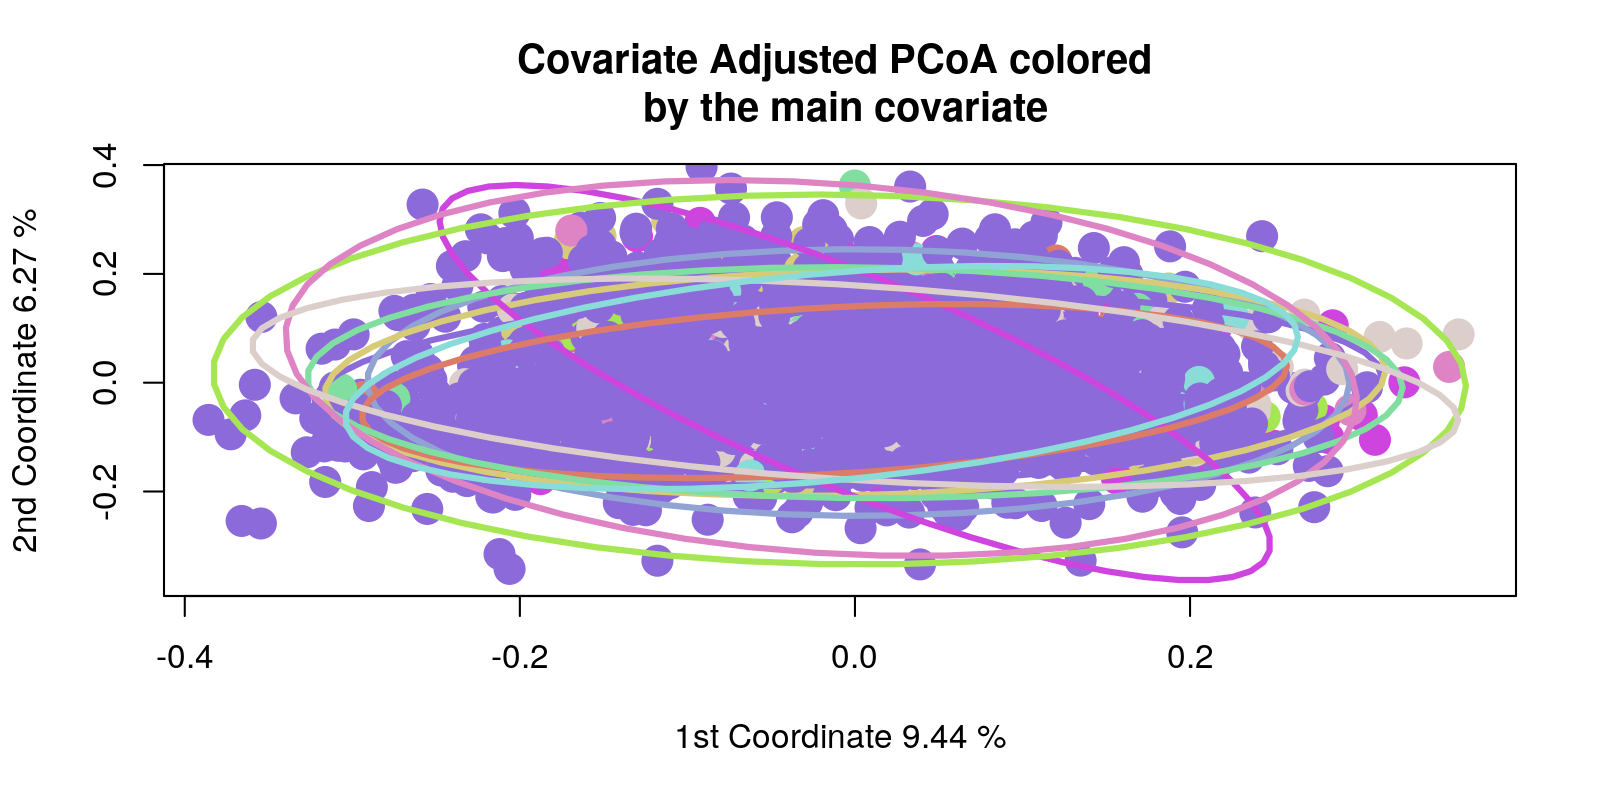

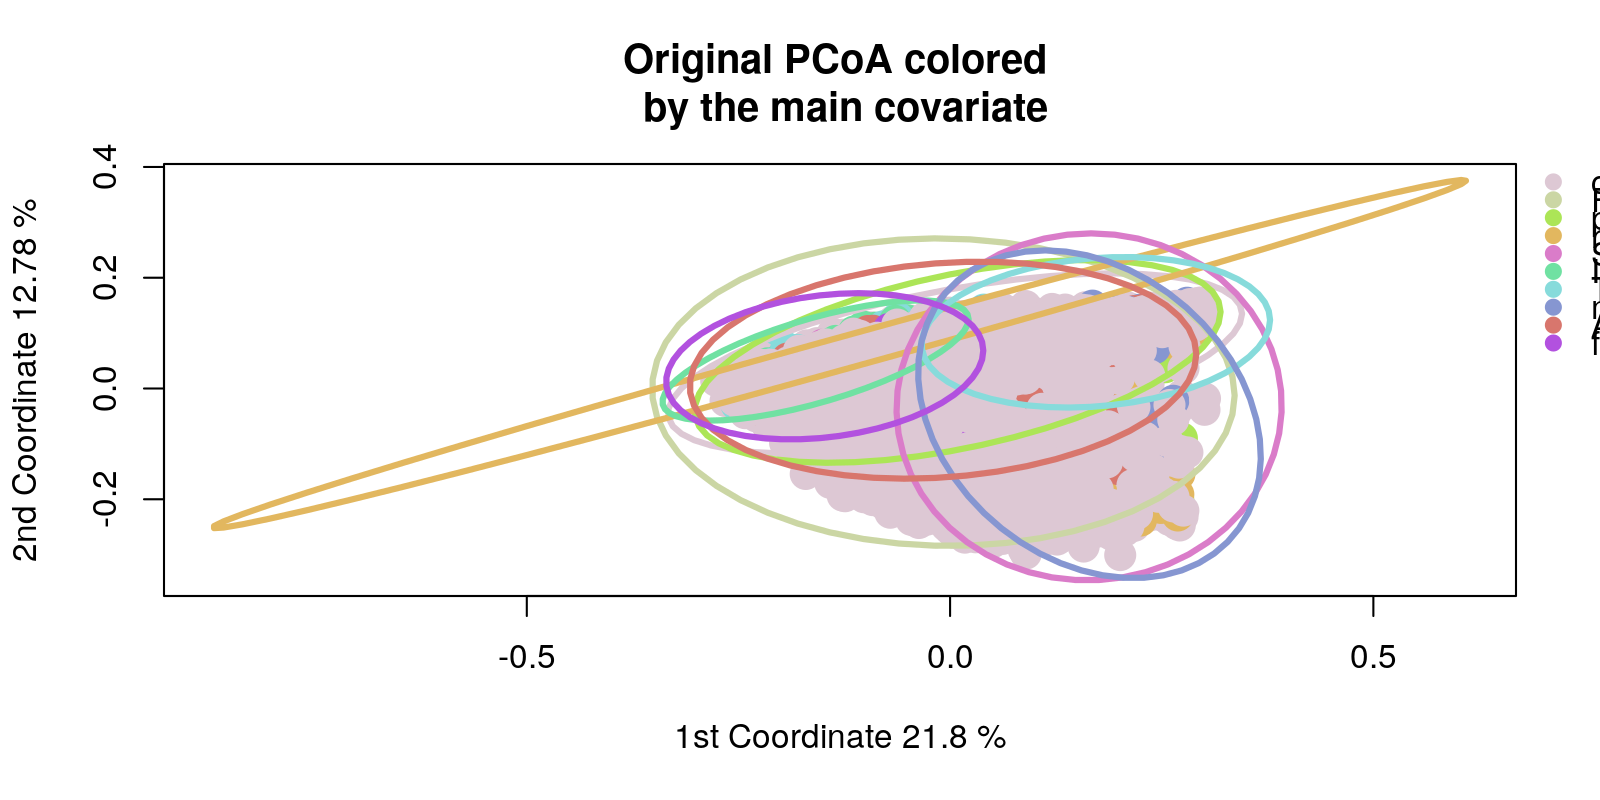

[1] 6

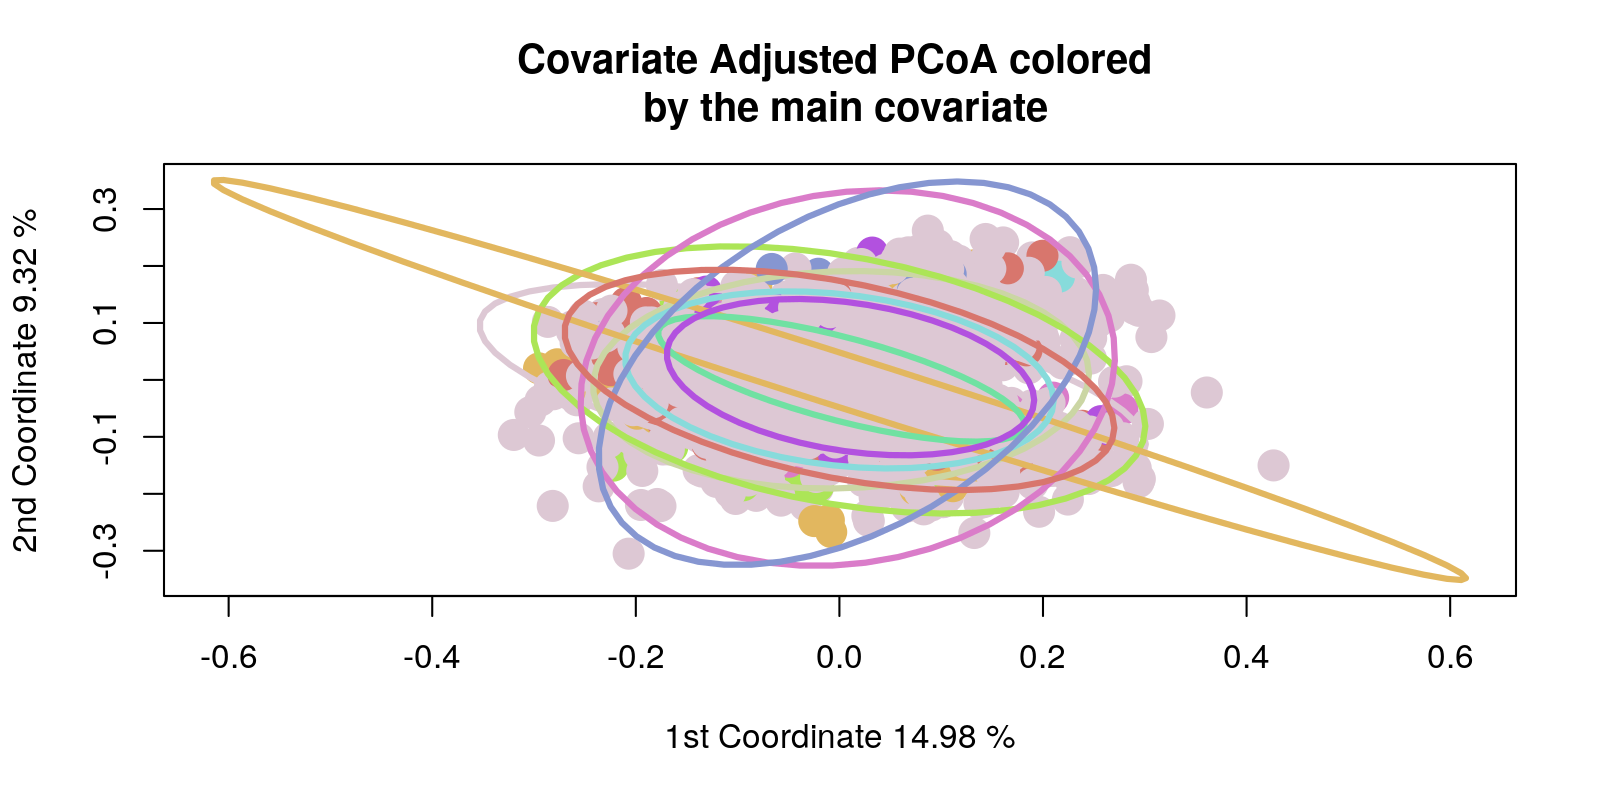

In [70]:
# aPCoA in parallel 
p.dims(8,4)
#doParallel::registerDoParallel(threads)
aPCoA_res = 1:length(D) %>%
    plyr::llply(aPCoA_per, D=D, m=m, .parallel=FALSE)
names(aPCoA_res) = D %>% names
aPCoA_res %>% length

In [71]:
# formatting
fmt_mat = function(res, meta){
    res = res$plotMatrix %>%
        as.data.frame %>%
        mutate(Sample = rownames(.)) %>%
        dt_select(Sample, V1, V2) %>%
        dt_inner_join(meta, c('Sample'))
    res
}

aPCoA_res_df = aPCoA_res %>% 
    lapply(fmt_mat, meta=meta) %>%
    data.table::rbindlist(use.names=TRUE, idcol='measure')

aPCoA_res_df 

measure      Sample            V1           V2          dataset_name 
1     bray         MV_FEM1_t1Q14      0.4033388    0.23177876 AsnicarF_2017
2     bray         MV_FEM2_t1Q14     -0.1096965   -0.04818505 AsnicarF_2017
⋮     ⋮            ⋮                 ⋮            ⋮           ⋮            
20087 wunifrac_trt PNP_Validation_45 -0.000964439 -0.1203844  ZeeviD_2015  
20088 wunifrac_trt PNP_Validation_46  0.290021938  0.1361574  ZeeviD_2015  
      subjectID         body_site antibiotics_current_use study_condition
1     MV_FEM1           stool     NA                      control        
2     MV_FEM2           stool     NA                      control        
⋮     ⋮                 ⋮         ⋮                       ⋮              
20087 PNP_Validation_45 stool     no                      control        
20088 PNP_Validation_46 stool     no                      control        
      disease ⋯ il_1 glp_1 travel_destination urea_nitrogen disease_stage
1     healthy ⋯ NA   NA    NA                 NA            NA           
2     healthy ⋯ NA   NA    NA                 NA            NA           
⋮     ⋮       ⋱ ⋮    ⋮     ⋮                  ⋮             ⋮            
20087 healthy ⋯ NA   NA    NA                 NA            NA           
20088 healthy ⋯ NA   NA    NA                 NA            NA           
      uncurated_metadata family_member subject_n samp_n westernized
1     NA                 NA            1         1      TRUE       
2     NA                 NA            1         1      TRUE       
⋮     ⋮                  ⋮             ⋮         ⋮      ⋮          
20087 NA                 NA            1         1      TRUE       
20088 NA                 NA            1         1      TRUE

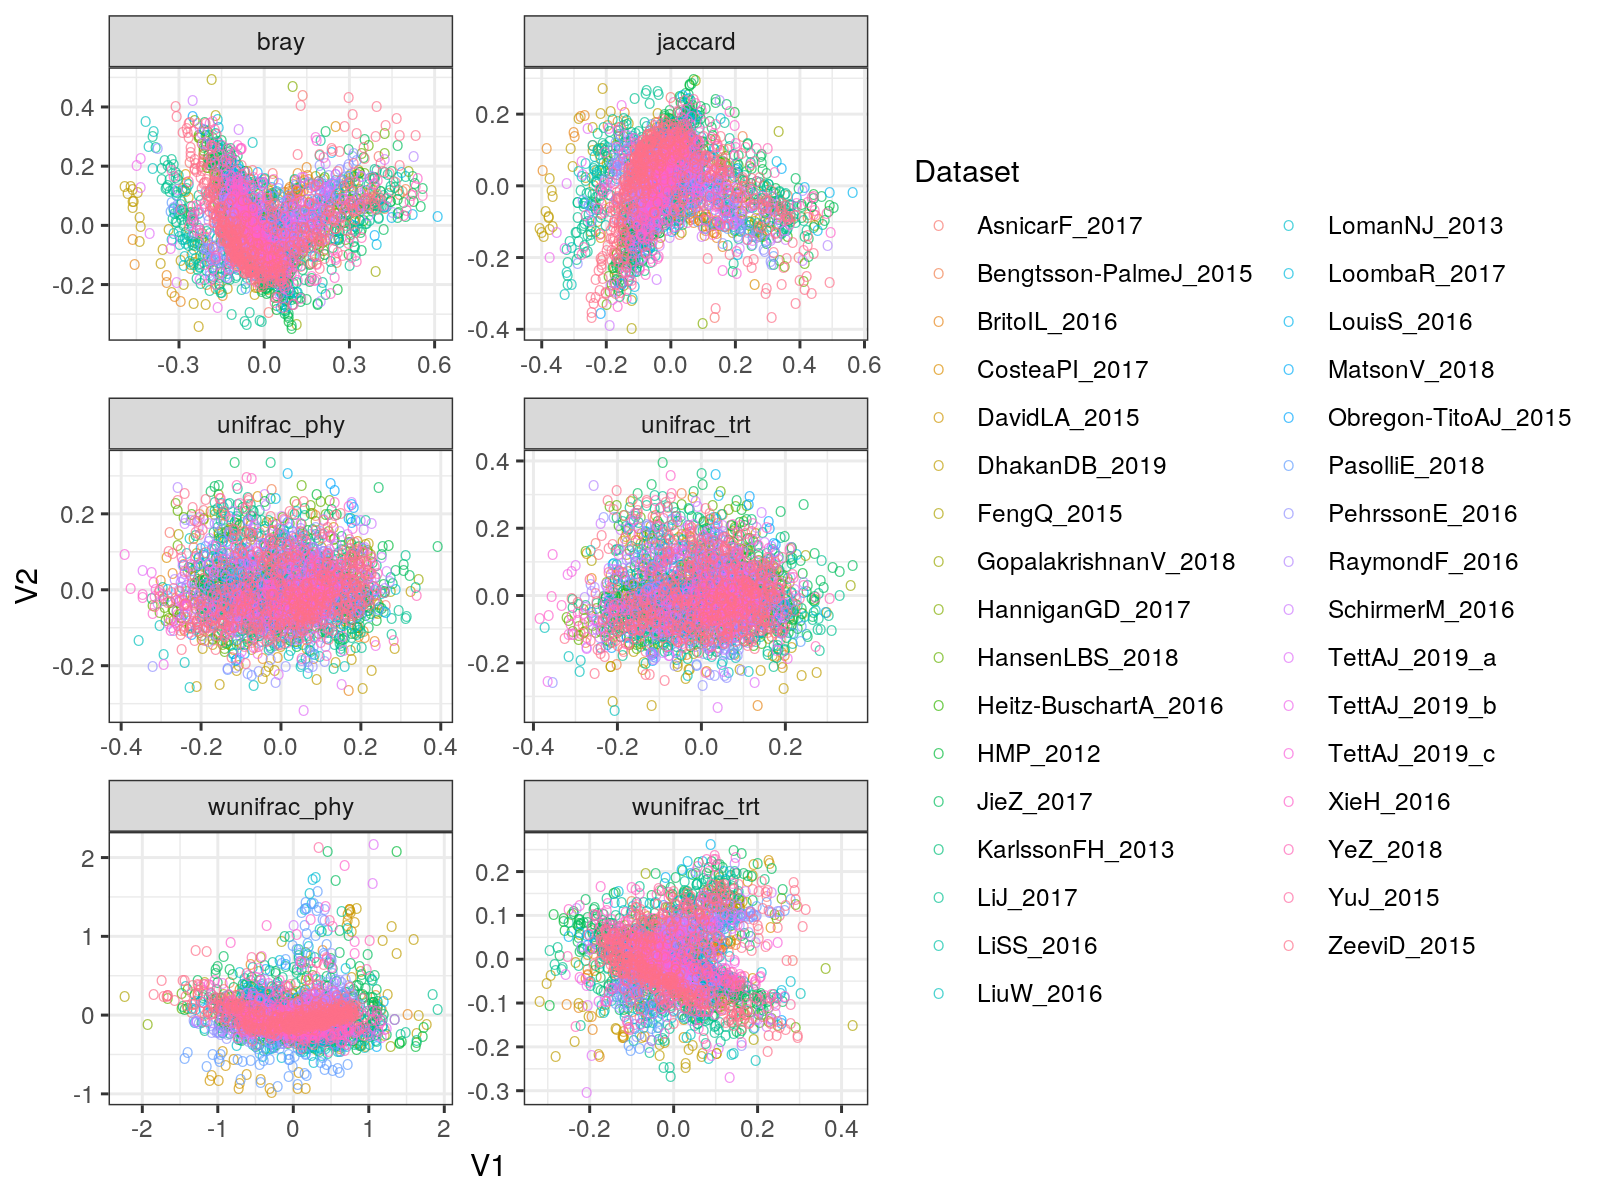

In [78]:
# plotting
p = aPCoA_res_df  %>%
    ggplot(aes(V1, V2, color=dataset_name)) +
    geom_point(alpha=0.7, shape='O') +
    facet_wrap(~ measure, scales='free', ncol=2) +
    scale_color_discrete('Dataset') +
    theme_bw()

p.dims(8,6)
plot(p)

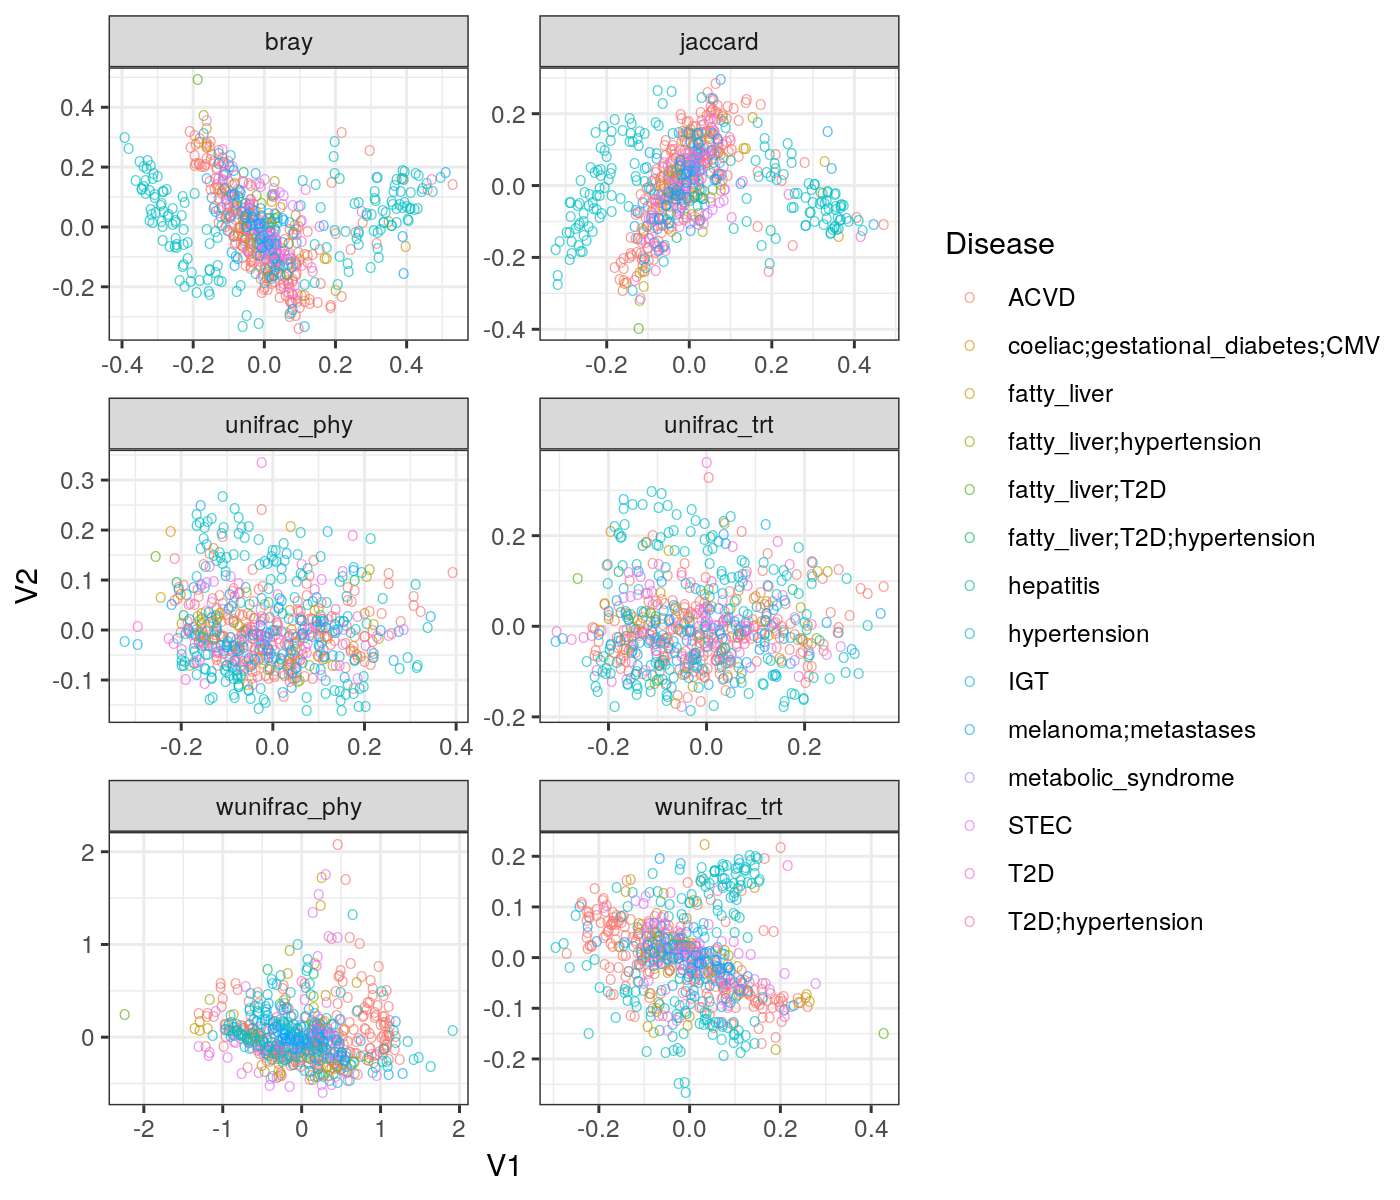

In [83]:
# plotting
p = aPCoA_res_df  %>%
    dt_filter(!is.na(disease), 
              disease != 'healthy') %>%
    ggplot(aes(V1, V2, color=disease)) +
    geom_point(alpha=0.7, shape='O') +
    facet_wrap(~ measure, scales='free', ncol=2) +
    scale_color_discrete('Disease') +
    theme_bw()

p.dims(7,6)
plot(p)

# sessionInfo

In [26]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.4 LTS

Matrix products: default
BLAS/LAPACK: /ebio/abt3_projects/Georg_animal_feces/envs/phyloseq-eco/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] aPCoA_1.1         LeyLabRMisc_0.1.6 vegan_2.5-6       lattice_0.20-38  
 [5] permute_0.9-5     phyloseq_1.30.0   ape_5.3           tidytable_0.4.1  
 [9] dtplyr_1.0.0      data.table_1.12.8 ggplot2_3.2.1     tidyr_1.0.0      
[13] dplyr_0.8.5      

loaded via a namespace (